In [1]:
import blockulib
import blockulib.models as blom
import matplotlib.pyplot as plt
import torch
from abc import ABC, abstractmethod

# PoitionList class
    Class used for storing information about the positions and return it in the playing loop.
    More PositionLists to be added.

In [61]:
class PositionList():
    def __init__(self, num_games, starting_positions = None):
        if starting_positions is None:
            self.pos_list = [[torch.zeros(9, 9)] for i in range(num_games)]
            self.num_games = num_games
        else:
            self.num_games = starting_positions.shape[0]
            self.pos_list = []
            for i in range(self.num_games):
                self.pos_list.append([starting_positions[i]])
                
        self.active_games = self.num_games
        self.state = torch.ones(self.num_games, dtype = torch.bool)
        
    def __call__(self,):
        return self.pos_list
    
    def active_boards(self,):
        self.new_index = torch.where(self.state == True)[0].tolist()
        return [self.pos_list[self.new_index[i]][-1].clone() for i in range(self.active_games)]
    
    def process_chosen_moves(self, chosen_moves):
        for i in range(self.active_games):
            if chosen_moves[i] is not None:
                self.pos_list[self.new_index[i]].append(chosen_moves[i])
            else:
                self.state[self.new_index[i]] = False
                self.active_games -= 1

## Some unit tests
Some Unit tests

In [63]:
class PositionListTests():
    
    def __call__(self, ):
        self.init_test(False)
        self.init_test(True)
    
    def init_test(self, init_from_games, num_games = 10):
        if init_from_games:
            games = torch.zeros((num_games, 9, 9))
            pos_list = PositionList("whatever", games)
        else:
            pos_list = PositionList(num_games = num_games)
        
        assert(num_games == pos_list.num_games)
        assert(num_games == pos_list.active_games)
        
        active_boards = pos_list.active_boards()
        assert(num_games == len(active_boards))
        for i in range(num_games):
            assert(torch.equal(torch.zeros(9, 9), active_boards[i]))
        
        expected_call_val = [[torch.zeros(9, 9)] for i in range(num_games)]
        self.compare_call_lists(expected_call_val, pos_list())
        
    def compare_call_lists(self, list1, list2):
        assert(len(list1) == len(list2))
        for i in range(len(list1)):
            assert(len(list1[i]) == len(list2[i]))
            for j in range(len(list1[i])):
                assert(torch.equal(list1[i][j], list2[i][j]))

In [65]:
tests = PositionListTests()
tests()

# New PlayingLoop structure
    work in progress - new Playing Loop structure will be more object oriented and hopefully faster thanks to PositionList

In [3]:
class PlayingLoop():
    
    def __init__(self,):
        self.generator = blockulib.BlockGenerator()
    
    def __call__(self, num_games = 1, pos_list = None):
        if pos_list is None:
            self.pos_list = [[torch.zeros(9, 9)] for i in range(num_games)]
            self.num_games = num_games
        else:
            self.num_games = len(pos_list)
            self.pos_list = pos_list
            
        self.state = torch.ones(self.num_games, dtype = torch.bool)
        self.active_games, self.move = self.num_games, 0
        
        while (self.active_games > 0 and self.continue_condition()):
            self.move += 1
            new_index = torch.where(self.state == True)[0].tolist()
            boards = [self.pos_list[new_index[i]][-1].clone() for i in range(self.active_games)]
            
            pos, ind = blockulib.possible_moves(boards, self.generator)
            
            chosen_moves = self.pick_moves(boards, pos, ind)
            for i in range(len(new_index)):
                if chosen_moves[i] is not None:
                    self.pos_list[new_index[i]].append(chosen_moves[i])
                else:
                    self.state[new_index[i]] = False
                    self.active_games -= 1
                
        return self.pos_list
    
    def continue_condition(self,):
        return True
    
    @abstractmethod
    def pick_moves(self, new_index, pos, ind):
        pass

In [4]:
class SimpleLoop(PlayingLoop):
    
    def pick_moves(self, new_index, pos, ind):
        chosen_moves = [None for i in range(len(new_index))]
        for i in range(ind.shape[0]):
            index = int(ind[i].item())
            if chosen_moves[index] is None:
                chosen_moves[index] = pos[i]
        return chosen_moves

In [18]:
class ModelBasedLoop(PlayingLoop):
    
    def __init__(self, model_path = "models/conv_model.pth", architecture = blom.ConvModel):
        super().__init__()
        self.model = architecture()
        state_dict = torch.load(model_path)
        self.model.load_state_dict(state_dict)
        self.model.eval()
        
    def pick_moves(self, new_index, pos, ind, pred_config = {}, rethink_config = {}, temperature = 1.0, top_k: int = 5):
        logits = self.get_model_pred(data = pos, **pred_config)
        pos, ind, logits = blockulib.cut_to_topk(pos, ind, logits, num_games = self.active_games, top_k = top_k)
        logits = self.rethink_logits(pos, logits, **rethink_config)
        decisions = blockulib.logits_to_choices(logits, ind, self.active_games, temperature = temperature, top_k = top_k)
        
        chosen_moves = [None for i in range(self.active_games)]
        for i in range(self.active_games):
            if decisions[i] is not None:
                chosen_moves[i] = pos[decisions[i]]
        return chosen_moves
                    
    def get_model_pred(self, data, batch_size = 2048, device = None):
        if (data.shape[0] == 0):
            return torch.tensor([])
        if device is None:
            device = ("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        predictions = []
        
        with torch.no_grad():
            for i in range(0, data.shape[0], batch_size):
                batch = data[i:i+batch_size].to(device)
                batch = batch.unsqueeze(1)
                output = self.model(batch)
                predictions.append(output.cpu())
            
        return torch.cat(predictions).squeeze(1)
    
    def rethink_logits(self, pos, logits):
        return logits

In [20]:
loop = ModelBasedLoop()

In [22]:
pos = loop(num_games = 2)
print(len(pos[0]))

20


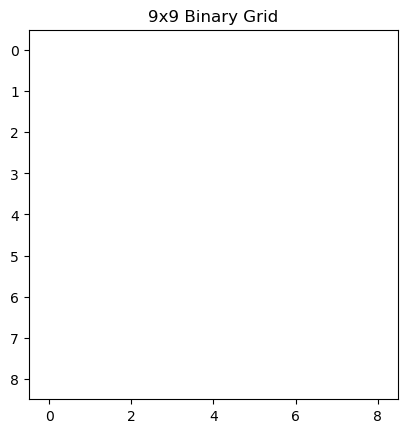

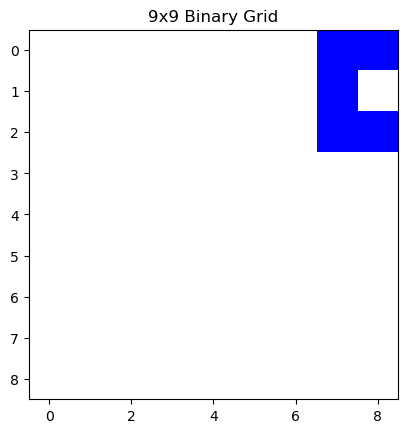

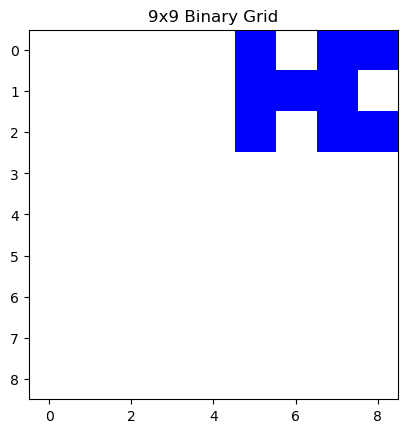

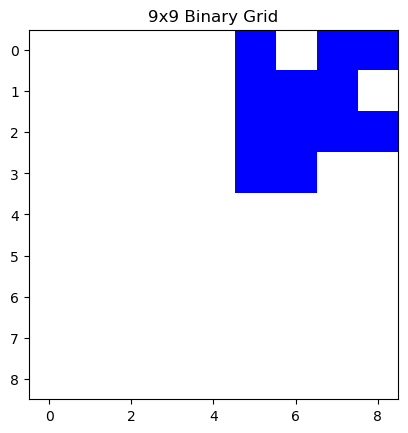

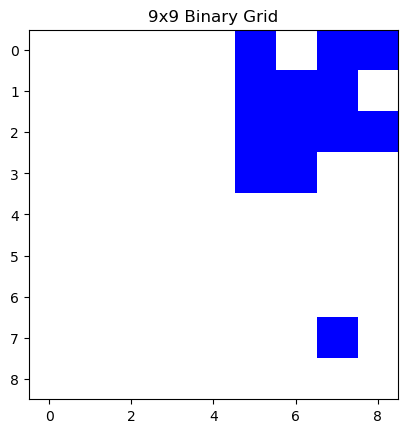

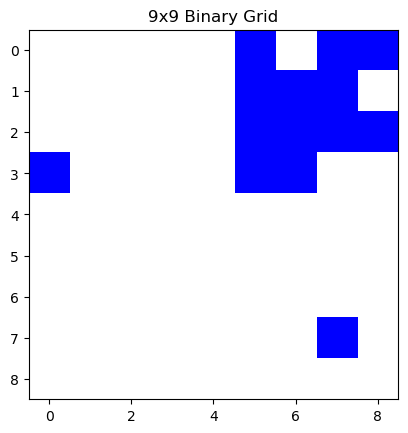

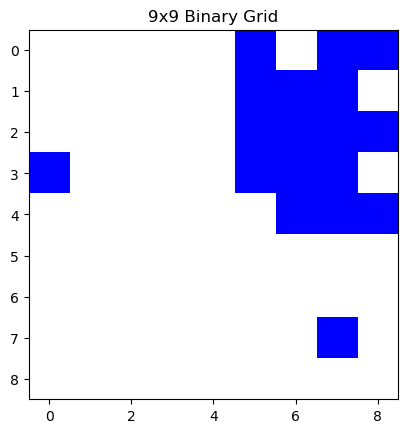

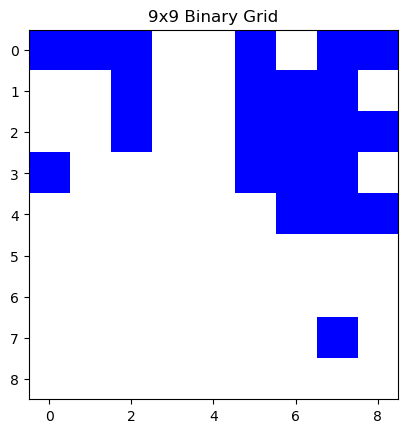

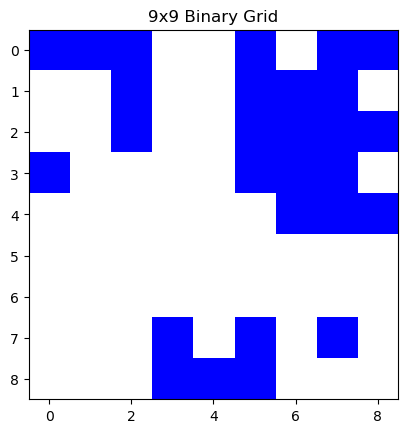

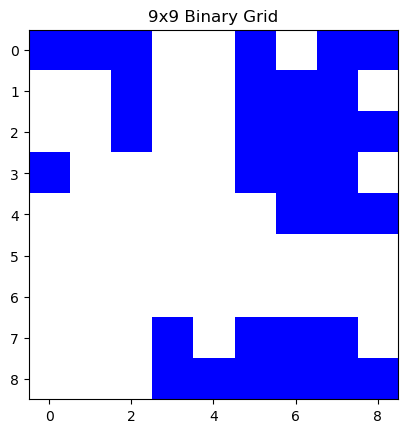

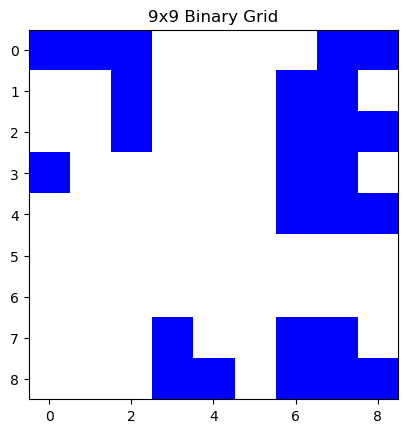

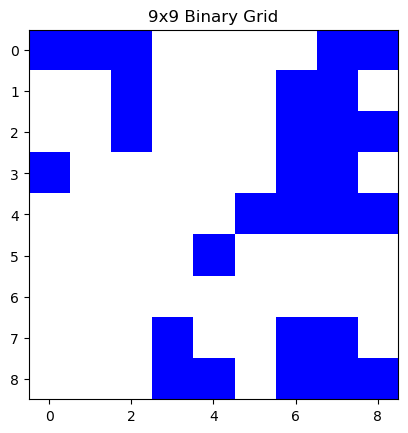

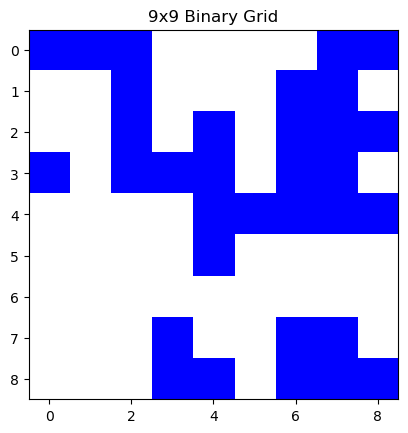

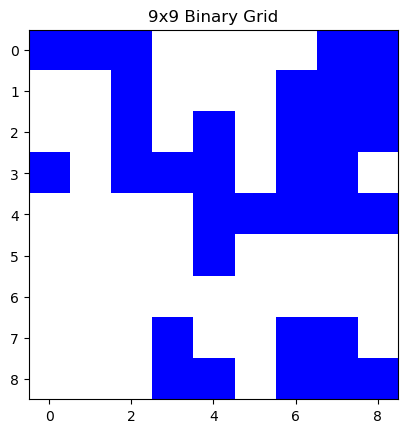

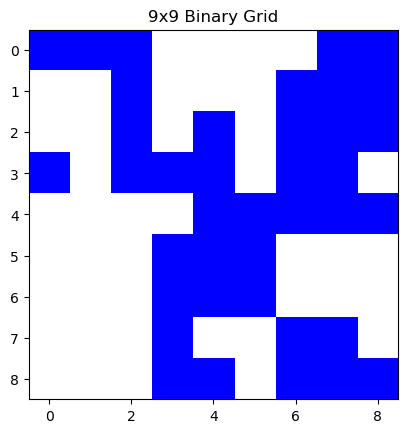

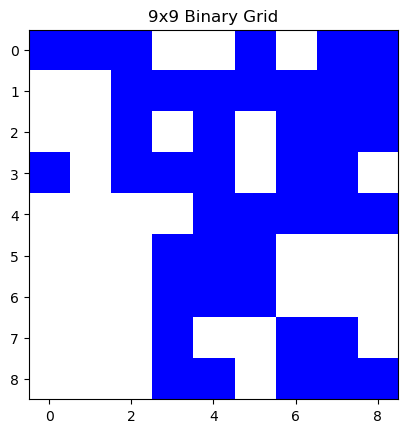

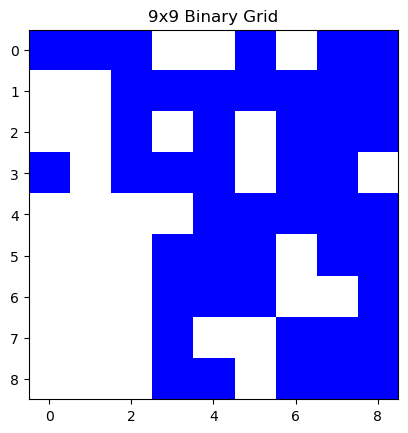

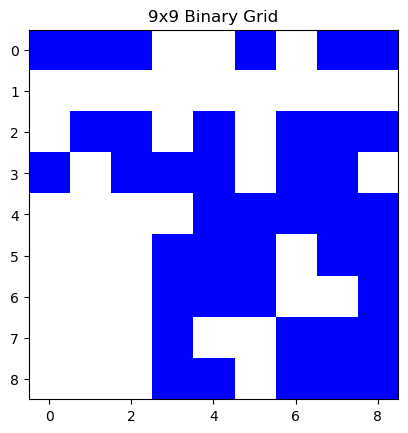

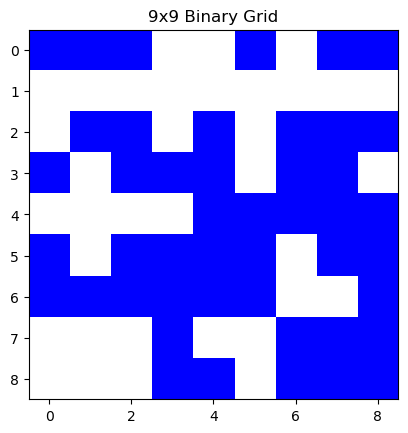

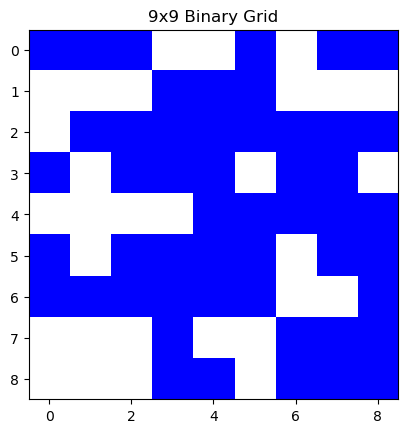

In [24]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def display_board(board):
    cmap = ListedColormap(["white", "blue"])

    plt.imshow(board, cmap=cmap, origin='upper', interpolation='nearest')
    plt.title("9x9 Binary Grid")
    plt.show()
    
for board in pos[0]:
   display_board(board) 

In [9]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [18]:
class ModelBasedLoop(PlayingLoop):
    
    def __init__(self, model_path = "models/conv_model.pth", architecture = blom.ConvModel):
        super().__init__()
        self.model = architecture()
        state_dict = torch.load(model_path)
        self.model.load_state_dict(state_dict)
        self.model.eval()
        
    def pick_moves(self, new_index, pos, ind, pred_config = {}, rethink_config = {}, temperature = 1.0, top_k: int = 5):
        logits = self.get_model_pred(data = pos, **pred_config)
        pos, ind, logits = blockulib.cut_to_topk(pos, ind, logits, num_games = self.active_games, top_k = top_k)
        logits = self.rethink_logits(pos, logits, **rethink_config)
        decisions = blockulib.logits_to_choices(logits, ind, self.active_games, temperature = temperature, top_k = top_k)
        
        chosen_moves = [None for i in range(self.active_games)]
        for i in range(self.active_games):
            if decisions[i] is not None:
                chosen_moves[i] = pos[decisions[i]]
        return chosen_moves
                    
    def get_model_pred(self, data, batch_size = 2048, device = None):
        if (data.shape[0] == 0):
            return torch.tensor([])
        if device is None:
            device = ("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        predictions = []
        
        with torch.no_grad():
            for i in range(0, data.shape[0], batch_size):
                batch = data[i:i+batch_size].to(device)
                batch = batch.unsqueeze(1)
                output = self.model(batch)
                predictions.append(output.cpu())
            
        return torch.cat(predictions).squeeze(1)
    
    def rethink_logits(self, pos, logits):
        return logits

In [4]:
class SimpleLoop(PlayingLoop):
    
    def pick_moves(self, new_index, pos, ind):
        chosen_moves = [None for i in range(len(new_index))]
        for i in range(ind.shape[0]):
            index = int(ind[i].item())
            if chosen_moves[index] is None:
                chosen_moves[index] = pos[i]
        return chosen_moves

In [18]:
class ModelBasedLoop(PlayingLoop):
    
    def __init__(self, model_path = "models/conv_model.pth", architecture = blom.ConvModel):
        super().__init__()
        self.model = architecture()
        state_dict = torch.load(model_path)
        self.model.load_state_dict(state_dict)
        self.model.eval()
        
    def pick_moves(self, new_index, pos, ind, pred_config = {}, rethink_config = {}, temperature = 1.0, top_k: int = 5):
        logits = self.get_model_pred(data = pos, **pred_config)
        pos, ind, logits = blockulib.cut_to_topk(pos, ind, logits, num_games = self.active_games, top_k = top_k)
        logits = self.rethink_logits(pos, logits, **rethink_config)
        decisions = blockulib.logits_to_choices(logits, ind, self.active_games, temperature = temperature, top_k = top_k)
        
        chosen_moves = [None for i in range(self.active_games)]
        for i in range(self.active_games):
            if decisions[i] is not None:
                chosen_moves[i] = pos[decisions[i]]
        return chosen_moves
                    
    def get_model_pred(self, data, batch_size = 2048, device = None):
        if (data.shape[0] == 0):
            return torch.tensor([])
        if device is None:
            device = ("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        predictions = []
        
        with torch.no_grad():
            for i in range(0, data.shape[0], batch_size):
                batch = data[i:i+batch_size].to(device)
                batch = batch.unsqueeze(1)
                output = self.model(batch)
                predictions.append(output.cpu())
            
        return torch.cat(predictions).squeeze(1)
    
    def rethink_logits(self, pos, logits):
        return logits

In [4]:
class SimpleLoop(PlayingLoop):
    
    def pick_moves(self, new_index, pos, ind):
        chosen_moves = [None for i in range(len(new_index))]
        for i in range(ind.shape[0]):
            index = int(ind[i].item())
            if chosen_moves[index] is None:
                chosen_moves[index] = pos[i]
        return chosen_moves

In [3]:
class PlayingLoop():
    
    def __init__(self,):
        self.generator = blockulib.BlockGenerator()
    
    def __call__(self, num_games = 1, pos_list = None):
        if pos_list is None:
            self.pos_list = [[torch.zeros(9, 9)] for i in range(num_games)]
            self.num_games = num_games
        else:
            self.num_games = len(pos_list)
            self.pos_list = pos_list
            
        self.state = torch.ones(num_games, dtype = torch.bool)
        self.active_games, self.move = num_games, 0
        
        while (self.active_games > 0 and self.continue_condition()):
            self.move += 1
            new_index = torch.where(self.state == True)[0].tolist()
            boards = [self.pos_list[new_index[i]][-1].clone() for i in range(self.active_games)]
            
            pos, ind = blockulib.possible_moves(boards, self.generator)
            
            chosen_moves = self.pick_moves(boards, pos, ind)
            for i in range(len(new_index)):
                if chosen_moves[i] is not None:
                    self.pos_list[new_index[i]].append(chosen_moves[i])
                else:
                    self.state[new_index[i]] = False
                    self.active_games -= 1
                
        return self.pos_list
    
    def continue_condition(self,):
        return True
    
    @abstractmethod
    def pick_moves(self, new_index, pos, ind):
        pass

In [ ]:
"""class PlayingLoop():
    
    def __init__(self,):
        self.generator = blockulib.BlockGenerator()
    
    def __call__(self, num_games = 1, pos_list = None):
        if pos_list is None:
            self.pos_list = [[torch.zeros(9, 9)] for i in range(num_games)]
            self.num_games = num_games
        else:
            self.num_games = len(pos_list)
            self.pos_list = pos_list
            
        self.state = [True for i in range(num_games)]
        self.active_games, self.move = num_games, 0
        
        while (self.active_games > 0 and self.continue_condition()):
            self.move += 1
            new_index = []
            for i in range(num_games):
                if self.state[i]:
                    new_index.append(i)
            boards = [self.pos_list[new_index[i]][-1].clone() for i in range(self.active_games)]
            
            pos, ind = blockulib.possible_moves(boards, self.generator)
            
            chosen_moves = self.pick_moves(boards, pos, ind)
            for i in range(len(new_index)):
                if chosen_moves[i] is not None:
                    self.pos_list[new_index[i]].append(chosen_moves[i])
                else:
                    self.state[new_index[i]] = False
                    self.active_games -= 1
                
        return self.pos_list
    
    def continue_condition(self,):
        return True
    
    @abstractmethod
    def pick_moves(self, new_index, pos, ind):
        pass"""